# Calculate RFM and CLV Values

## Step 1: Load Data

In [1]:
import pandas as pd
df = pd.read_csv("https://ucarecdn.com/8d8cd2ee-47d4-474f-b3a7-66eb9a20b43e/retail_data_clean.csv")
df.head()

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Quantity,UnitPrice,Revenue
0,13047,536367,2010-12-01 08:34:00,84879,32,1.69,54.08
1,13047,536367,2010-12-01 08:34:00,22745,6,2.10,12.60
2,13047,536367,2010-12-01 08:34:00,22748,6,2.10,12.60
3,13047,536367,2010-12-01 08:34:00,22749,8,3.75,30.00
4,13047,536367,2010-12-01 08:34:00,22310,6,1.65,9.90


In [4]:
df["InvoiceDate"] = pd.to_datetime(df['InvoiceDate'])

## Step 2: RFM—Recency

In [5]:
def recency(dates):
  recency = (dates.max() - dates.min()).days
  return(recency)

In [6]:
recency_df = df.groupby("CustomerID").agg({
    "InvoiceDate": [("Recency", recency)]
    })
recency_df = recency_df.droplevel(0, axis = 1)
recency_df.head()

,Recency
CustomerID,
12347,365
12349,0
12363,132
12370,309
12381,115


In [7]:
recency_df.describe()

,Recency
count,1000.000000
mean,133.083000
std,133.994719
min,0.000000
25%,0.000000
50%,94.500000
75%,258.000000
max,372.000000


<AxesSubplot:ylabel='Frequency'>

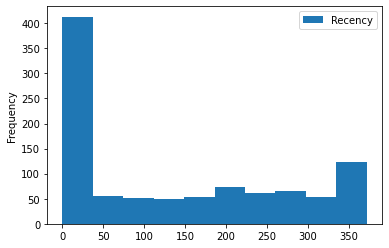

In [8]:
recency_df.plot.hist()

## Step 3 - RFM—Frequency

In [9]:
def frequency(series):
  frequency = series.nunique() - 1
  return(frequency)

In [10]:
frequency_df = df.groupby("CustomerID").agg({
    "InvoiceDate": [frequency]
    })
frequency_df = frequency_df.droplevel(0, axis = 1)
frequency_df.head()

,frequency
CustomerID,
12347,6
12349,0
12363,1
12370,3
12381,2


In [11]:
frequency_df.describe()

,frequency
count,1000.000000
mean,3.294000
std,9.085379
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,206.000000


<AxesSubplot:ylabel='Frequency'>

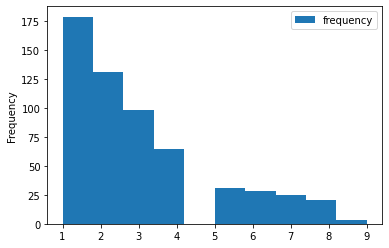

In [12]:
(frequency_df[(frequency_df['frequency'] < 10) & (frequency_df['frequency'] > 0)]
.plot
.hist())

## Step 4: RFM—Monetary Value

In [13]:
# Mean, Total or Max depends on the business
monetary_df = df.groupby("CustomerID").agg({
    "Revenue": ["sum", "mean"]
    })
monetary_df.head()

Revenue           
                sum       mean
CustomerID                    
12347       4310.00  23.681319
12349       1457.55  20.243750
12363        552.00  24.000000
12370       3425.69  20.636687
12381       1474.81  17.985488

In [14]:
monetary_df.describe()

Revenue             
                 sum         mean
count    1000.000000  1000.000000
mean     1903.579220    33.596410
std      7959.611509   137.261024
min        25.500000     2.101286
25%       307.027500    12.071165
50%       633.510000    17.793667
75%      1631.830000    24.160758
max    194550.790000  3861.000000

## Step 5: Combine Metrics—RFM Scores

In [15]:
rfm_df = df.groupby("CustomerID").agg({
    "Revenue": ["mean"],
    "InvoiceDate": [frequency, recency]
    })
rfm_df.head()

Revenue InvoiceDate        
                 mean   frequency recency
CustomerID                               
12347       23.681319           6     365
12349       20.243750           0       0
12363       24.000000           1     132
12370       20.636687           3     309
12381       17.985488           2     115

In [16]:
quantiles = rfm_df.quantile(q=[0.2,0.4,0.6,0.8])
quantiles

Revenue InvoiceDate        
          mean   frequency recency
0.2   9.447344         0.0     0.0
0.4  16.165571         1.0    29.6
0.6  19.463160         2.0   172.0
0.8  26.511398         4.0   279.0

In [17]:
quantiles = rfm_df[rfm_df['InvoiceDate']['frequency'] > 0].quantile(q=[0.25,0.5,0.75])
quantiles

Revenue InvoiceDate        
           mean   frequency recency
0.25  12.359208         1.0  104.00
0.50  18.247701         3.0  213.50
0.75  24.554084         5.0  308.25

In [18]:
max_revenue = rfm_df['Revenue']['mean'].max()
max_recency = rfm_df['InvoiceDate']['recency'].max()
max_frequency = rfm_df['InvoiceDate']['recency'].max()

rfm_df['RecencyScore'] = pd.cut(rfm_df['InvoiceDate']['recency'], bins = [-1, 0, 104, 213.5, 308.25, max_recency], labels = ["1", "2","3","4","5"])
rfm_df['FrequencyScore'] = pd.cut(rfm_df['InvoiceDate']['frequency'], bins = [-1, 0, 1, 3, 5, max_frequency], labels = ["1", "2","3","4","5"])
rfm_df['MonetaryScore'] = pd.cut(rfm_df['Revenue']['mean'], bins = [0, 9.45, 16.16, 19.46, 26.51, max_revenue] , labels = ["1","2","3","4","5"])

In [19]:
rfm_df.head()

Revenue InvoiceDate         RecencyScore FrequencyScore  \
                 mean   frequency recency                               
CustomerID                                                              
12347       23.681319           6     365            5              5   
12349       20.243750           0       0            1              1   
12363       24.000000           1     132            3              2   
12370       20.636687           3     309            5              3   
12381       17.985488           2     115            3              3   

           MonetaryScore  
                          
CustomerID                
12347                  4  
12349                  4  
12363                  4  
12370                  4  
12381                  3

In [20]:
rfm_df['RfmScore'] = rfm_df['RecencyScore'].astype(str) + rfm_df['FrequencyScore'].astype(str) + rfm_df['MonetaryScore'].astype(str)
rfm_df['RfmScore'] = rfm_df['RfmScore'].astype(int)

In [21]:
rfm_df.sort_values(["RfmScore", ('Revenue', 'mean')], ascending = False).head(10)

Revenue InvoiceDate         RecencyScore FrequencyScore  \
                  mean   frequency recency                               
CustomerID                                                               
17450       577.302047          45     359            5              5   
17857       527.115417          21     361            5              5   
16013       267.126619          43     367            5              5   
17381       186.014771          28     363            5              5   
12664       156.852857           8     314            5              5   
15061       135.320447          45     368            5              5   
14156        84.159791          52     361            5              5   
13199        83.068814          34     363            5              5   
15465        75.820825          17     349            5              5   
14051        74.335190          22     365            5              5   

           MonetaryScore RfmScore  
                                   
CustomerID                         
17450                  5      555  
17857                  5      555  
16013                  5      555  
17381                  5      555  
12664                  5      555  
15061                  5      555  
14156                  5      555  
13199                  5      555  
15465                  5      555  
14051                  5      555